# Semantic Similarity Search with Embeddings
This notebook demonstrates text embeddings, similarity search, and vector database operations using SentenceTransformers and ChromaDB.

## 1. Import Required Libraries

In [10]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance

## 2. Load Text Collection

In [40]:
texts = [
    # News/Information
    "Climate change accelerates global warming trends",
    "Stock market reaches record highs",
    "New renewable energy breakthrough announced",
    "Tech companies report record profits",
    "Scientists discover new species in Amazon",

    # Sports
    "Championship team wins trophy after playoffs",
    "Athletic performance improves with training",
    "Olympic records broken in swimming",
    "Basketball star signs major contract",
    "Soccer tournament draws record attendance",

    # Entertainment
    "Movie wins Best Picture at awards ceremony",
    "New album released by popular artist",
    "TV series reaches 100 million viewers",
    "Theater production gets standing ovation",
    "Concert tour announced for summer",

    # Technology
    "Artificial intelligence transforms industry",
    "New smartphone features announced",
    "Cloud computing adoption increases",
    "Cybersecurity threats on the rise",
    "Software developers create innovative app"
]

## 3. Load Embedding Model and Generate Embeddings

In [41]:
# Load the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for all texts
embeddings = model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1662.50it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


## 4. t-SNE Dimensionality Reduction and Visualization

In [42]:
# Apply t-SNE for dimensionality reduction
def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    return tsne.fit_transform(embeddings)

embeddings_2d = apply_tsne(np.array(embeddings))

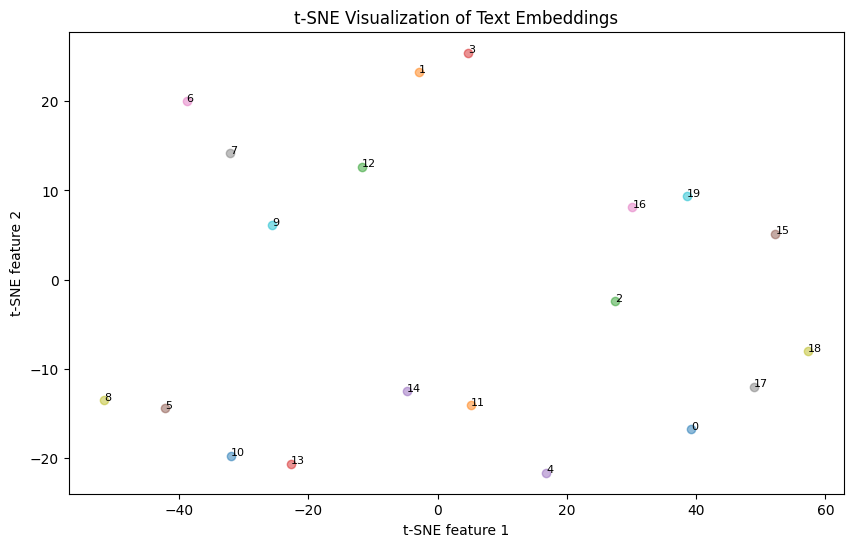

In [43]:
# Plot the t-SNE results
def plot_tsne(tsne_results, texts):
    plt.figure(figsize=(10, 6))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8)
    plt.title("t-SNE Visualization of Text Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d, texts)

## 5. Semantic Classification by Category

In [44]:
# Define categories for semantic classification
categories = ["Technology", "Sports", "Entertainment", "News", "Science"]

# Generate embeddings for categories
category_embeddings = model.encode(categories, convert_to_numpy=True)

In [45]:
# Function to categorize text by semantic similarity
def categorize_feedback(text_embedding, category_embeddings, categories):
    # Calculate cosine distance between text and each category
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index": i}
                    for i, cat_emb in enumerate(category_embeddings)]
    # Find the category with minimum distance
    closest = min(similarities, key=lambda x: x["distance"])
    return categories[closest["index"]]

# Categorize all texts
text_categories = [categorize_feedback(embedding, category_embeddings, categories) for embedding in embeddings]
for text, cat in zip(texts, text_categories):
    print(f"{cat}: {text}")

Technology: Climate change accelerates global warming trends
News: Stock market reaches record highs
News: New renewable energy breakthrough announced
Technology: Tech companies report record profits
Science: Scientists discover new species in Amazon
Sports: Championship team wins trophy after playoffs
Sports: Athletic performance improves with training
Sports: Olympic records broken in swimming
Sports: Basketball star signs major contract
Sports: Soccer tournament draws record attendance
Entertainment: Movie wins Best Picture at awards ceremony
News: New album released by popular artist
Entertainment: TV series reaches 100 million viewers
Entertainment: Theater production gets standing ovation
Entertainment: Concert tour announced for summer
Technology: Artificial intelligence transforms industry
News: New smartphone features announced
Technology: Cloud computing adoption increases
Technology: Cybersecurity threats on the rise
Technology: Software developers create innovative app


## 6. Vector Database Storage with ChromaDB

In [46]:
# Initialize ChromaDB
client = chromadb.PersistentClient()

# Create a collection for storing embeddings
collection = client.get_or_create_collection(name="text_embeddings")

# Store embeddings in the vector database
collection.add(
    documents=texts,
    ids=[str(i) for i in range(len(texts))],
    embeddings=embeddings
)

## 7. Query Similar Texts

In [47]:
# Function to find similar texts
def find_similar_texts(input_text, collection, n=3):
    """Find similar texts from the collection based on semantic similarity.
    
    Args:
        input_text (str): Query text to find similarities for.
        collection: ChromaDB collection to search in.
        n (int): Number of similar results to return.
        
    Returns:
        tuple: (results dict, similarity_scores list)
    """
    query_embedding = model.encode([input_text], convert_to_numpy=True).tolist()
    results = collection.query(
        query_embeddings=query_embedding,
        n_results=n,
        include=["documents", "distances"]
    )
    
    distances = results["distances"][0]
    similarity_scores = [round(1 / (1 + dist), 3) for dist in distances]
    
    return results, similarity_scores

# Example: Find similar texts to a query
example_text = "Technology and innovation"
results, similarity_scores = find_similar_texts(example_text, collection, n=3)

print("Similar texts found (with similarity scores):")
for i, (text, score) in enumerate(zip(results["documents"][0], similarity_scores), 1):
    print(f"{i}. {text} (score: {score})")

Similar texts found (with similarity scores):
1. Software developers create innovative app (score: 0.47)
2. Artificial intelligence transforms industry (score: 0.462)
3. Cloud computing adoption increases (score: 0.422)
